In [1]:
library(reticulate)
use_condaenv(condaenv="pyr2", conda="/data8t_0/hms/anaconda3/bin/conda")
# use_python("/data8t_0/hms/anaconda3/envs/pyr2/bin/python")
# umap<-import('umap')

In [2]:
library(Seurat)
library(data.table)
library(ggplot2)
library(flexclust)
suppressMessages(suppressWarnings(library(stringr)))
suppressMessages(suppressWarnings(library(dplyr)))
datasetName = "colon_colon_Kinchen2018"
dataFormat = 'tsv'
setwd(paste0("/stor/public/hcad/db_v1/",datasetName,"/"))

Loading required package: grid

Loading required package: lattice

Loading required package: modeltools

Loading required package: stats4



In [3]:
# Load the organized dataset
if(dataFormat == 'tsv'){
    data.matrix <- read.table(paste0(datasetName,"_expression.tsv"),h = T,sep='\t',row.names = 1)
} else{
   system(paste0("tar -zxvf ", datasetName, "_expression.tsv.gz")) #Invoke the unix command
   data.matrix <- Read10X(data.dir = paste0(datasetName,"_expression"))
   # data.dir: Directory containing the matrix.mtx, genes.tsv (or features.tsv), and barcodes.tsv files provided by 10X.
}
# Load the metadata and annotation
data.metadata <- read.table(file = paste0(datasetName,"_metadata.tsv"), h = T, sep = "\t", row.names = 5)
data.annotation <- read.table(file = paste0(datasetName,"_annotation.tsv"), h = T, sep = "\t", row.names = 1)
if (file.exists(paste0(datasetName,"_annotation2.tsv"))) {
    data.annotation2 <- read.table(file = paste0(datasetName,"_annotation2.tsv"), h = T, sep = "\t", row.names = 1)
}

In [4]:
ncol(data.matrix)

[1] 4378

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


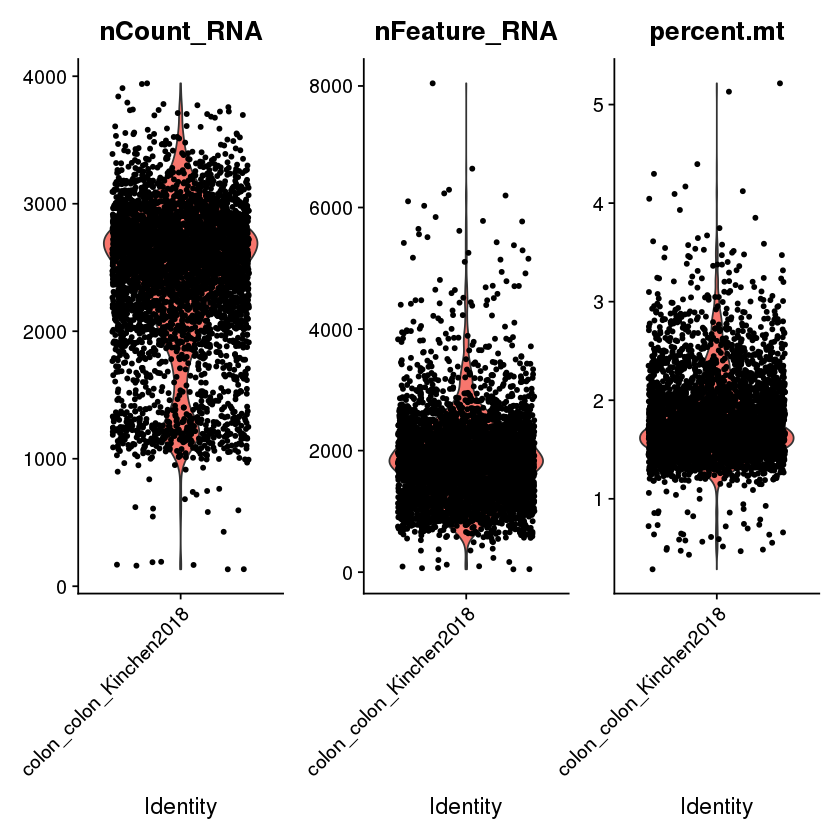

In [5]:
# Pre-processing
min.features = 20
# Modify the default value of these parameters according to original paper
dataobj <- CreateSeuratObject(counts = data.matrix, project = datasetName, min.features = min.features, meta.data = data.metadata)
dataobj <- AddMetaData(dataobj, metadata = data.annotation)

if (file.exists(paste0(datasetName,"_annotation2.tsv"))) {
    dataobj <- AddMetaData(dataobj, metadata = data.annotation2)
}
dataobj[["percent.mt"]] <- PercentageFeatureSet(dataobj, pattern = "^[Mm][Tt]")
VlnPlot(object = dataobj, features= c("nCount_RNA","nFeature_RNA","percent.mt"))

In [7]:
head(dataobj[[]])

,orig.ident,nCount_RNA,nFeature_RNA,organ,region,subregion,sample_status,donor_ID,donor_gender,donor_age,cell_cluster,percent.mt
,<fct>,<dbl>,<int>,<fct>,<fct>,<lgl>,<fct>,<fct>,<fct>,<int>,<lgl>,<dbl>
AAACCTGCAAGGACTG.S66,colon_colon_Kinchen2018,2775.124,2313,Colon,Colon,NA,normal,S66,Male,55,NA,1.477396
AAACCTGCACAACTGT.S66,colon_colon_Kinchen2018,2151.229,1133,Colon,Colon,NA,normal,S66,Male,55,NA,1.914844
AAACCTGCACCCTATC.S66,colon_colon_Kinchen2018,2298.313,1449,Colon,Colon,NA,normal,S66,Male,55,NA,2.092093
AAACCTGCAGGCTCAC.S66,colon_colon_Kinchen2018,2119.602,1272,Colon,Colon,NA,normal,S66,Male,55,NA,1.958543
AAACCTGCAGTCTTCC.S66,colon_colon_Kinchen2018,2584.286,1873,Colon,Colon,NA,normal,S66,Male,55,NA,1.781820
AAACCTGGTCATACTG.S66,colon_colon_Kinchen2018,2573.748,1581,Colon,Colon,NA,normal,S66,Male,55,NA,1.794376


In [8]:
dataobj <- subset(dataobj, subset = nCount_RNA>1200)
dataobj

An object of class Seurat 
33694 features across 4177 samples within 1 assay 
Active assay: RNA (33694 features, 0 variable features)

In [9]:
warnings('off')
dataobj <- NormalizeData(dataobj, normalization.method = "LogNormalize", scale.factor = 10000)

In [11]:
# *--------------------Load reference table--------------------*
print("=========Loading Reference Table=========")
ref_table_raw <- read.csv("/data8t_0/hms/workspace/HCA-d/Rtoolkit_GeneSymbolUniform/GeneSymbolRef_SelectAll_upd0731.csv", header=TRUE, na.strings=TRUE, stringsAsFactors=FALSE)
# print(dim(ref_table_raw))
print("Finished")
# *--------------------Load total gene list--------------------*
print("=========Processing Gene List=========")
total_gene_list_raw = read.table("/data8t_0/hms/workspace/HCA-d/Rtoolkit_GeneSymbolUniform/total_gene_list_43878.txt", 
                                 header=TRUE, sep='\t', fill=TRUE, stringsAsFactors=FALSE)
total_gene_list = total_gene_list_raw[,1]
# Seurat changes all "_" to "-".
total_gene_list <- str_replace(total_gene_list, "_", "-")
print("The length of gene list is: ")
print(length(total_gene_list))
print("Finished")
print("=========Processing Reference Table=========")
# Separate dataframe to previous and alias symbol sub-dataframe
# Remove duplicates and empty values
ref_table_raw <- ref_table_raw[,c("Approved.symbol","Alias.symbol","Previous.symbol")]
ref_table <- ref_table_raw[ref_table_raw[,"Previous.symbol"]!="" | ref_table_raw[,"Alias.symbol"]!="",]
# Seurat changes all "_" to "-".
ref_table$Previous.symbol <- str_replace(ref_table$Previous.symbol, "_", "-")
ref_table$Alias.symbol <- str_replace(ref_table$Alias.symbol, "_", "-")
ref_table$Approved.symbol <- str_replace(ref_table$Approved.symbol, "_", "-")
# print(dim(ref_table))
ref_table_prev <- unique(ref_table[,c("Approved.symbol","Previous.symbol")])
ref_table_prev <- ref_table_prev[ref_table_prev[,"Previous.symbol"]!="",]
ref_table_alia <- unique(ref_table[,c("Approved.symbol","Alias.symbol")])
ref_table_alia <- ref_table_alia[ref_table_alia[,"Alias.symbol"]!="",]
# print(dim(ref_table_prev))
# print(dim(ref_table_alia))
print("Finished")

# *--------------------Load query data--------------------*
print("=========Loading Query Data=========")
query_data <- as.data.frame(as.matrix(dataobj@assays$RNA@data))
query_gene_list <- rownames(dataobj)
print("The shape of query data is: ")
print(dim(query_data))
print("Print out first 5 genes in query data, in case something wrong happens in data loading: ")
print(query_gene_list[1:5])
print("Finished")

# *--------------------Perform gene name uniform--------------------*
print("=========Performing Gene Symbol Uniform=========")
print("Performing gene symbol uniform, this step may take several minutes")
gene_appearance_list <- data.frame(gene_name=total_gene_list, appearance=rep(FALSE, length(total_gene_list)))
outlier_gene_list <- c()

result_data <- query_data
result_data$genenames <- rownames(result_data)
report <- data.frame(Original.Name=character(), Modified.Name=character(), Status=character(), stringsAsFactors=FALSE)

for (i in c(1:length(query_gene_list))){
  gene_name <- query_gene_list[i]
  # Modify gene symbols, both "Alias symbol" and "Previous symbol" are used. 
  if(sum(ref_table_prev["Previous.symbol"]==gene_name)>0){
    # Multiple names matched
    if(sum(ref_table_prev["Previous.symbol"]==gene_name)>1){
      candidate_names <- paste(ref_table_prev[ref_table_prev[,"Previous.symbol"]==gene_name,"Approved.symbol"], collapse='|')
      report[i,] <- c(gene_name, candidate_names, "Multiple Candidates")
      if(gene_name %in% total_gene_list){
        gene_appearance_list[gene_appearance_list[,"gene_name"]==gene_name,"appearance"] = TRUE
      }
      else{
        outlier_gene_list <- c(outlier_gene_list, gene_name)
      }
    }
    # Only one name matched
    else{
      candidate_names <- ref_table_prev[ref_table_prev[,"Previous.symbol"]==gene_name,"Approved.symbol"]
      result_data[i:dim(result_data)[1],"genenames"][result_data[i:dim(result_data)[1],"genenames"]==gene_name] <- candidate_names
      report[i,] <- c(gene_name, candidate_names, "Changed")
      if(candidate_names %in% total_gene_list){
        gene_appearance_list[gene_appearance_list[,"gene_name"]==candidate_names,"appearance"] = TRUE
      }
      else{
        outlier_gene_list <- c(outlier_gene_list, candidate_names)
      }
    }
  }
    
  else if(sum(ref_table_alia["Alias.symbol"]==gene_name)>0){
    # Multiple names matched
    if(sum(ref_table_alia["Alias.symbol"]==gene_name)>1){
      candidate_names <- paste(ref_table_alia[ref_table_alia[,"Alias.symbol"]==gene_name,"Approved.symbol"], collapse='|')
      report[i,] <- c(gene_name, candidate_names, "Multiple Candidates")
      if(gene_name %in% total_gene_list){
        gene_appearance_list[gene_appearance_list[,"gene_name"]==gene_name,"appearance"] = TRUE
      }
      else{
        outlier_gene_list <- c(outlier_gene_list, gene_name)
      }
    }
    # Only one name matched
    else{
      candidate_names <- ref_table_alia[ref_table_alia[,"Alias.symbol"]==gene_name,"Approved.symbol"]
      result_data[i:dim(result_data)[1],"genenames"][result_data[i:dim(result_data)[1],"genenames"]==gene_name] <- candidate_names
      report[i,] <- c(gene_name, candidate_names, "Changed")
      if(candidate_names %in% total_gene_list){
        gene_appearance_list[gene_appearance_list[,"gene_name"]==candidate_names,"appearance"] = TRUE
      }
      else{
        outlier_gene_list <- c(outlier_gene_list, candidate_names)
      }
    }
  }
  
  # Gene name not found
  else{
    report[i,] <- c(gene_name, gene_name, "No Change")
    if(gene_name %in% total_gene_list){
      gene_appearance_list[gene_appearance_list[,"gene_name"]==gene_name,"appearance"] = TRUE
    }
    else{
      outlier_gene_list <- c(outlier_gene_list, gene_name)
    }
  }
}
print("Finished")

# *--------------------Construct uniform output--------------------*
print("=========Building Output Matrix=========")
result_data_grouped <- result_data %>% group_by(genenames) %>% summarise_at(vars(-group_cols()), mean)
result_data_sub <- as.data.frame(result_data_grouped)[which(!result_data_grouped$genenames %in% outlier_gene_list),]
result_data_out <- subset(result_data_sub, select = -genenames )
rownames(result_data_out) <- result_data_sub$genenames
print("Shape of processed query data: ")
print(dim(result_data_out))

add_df <- data.frame(matrix(nrow=sum(gene_appearance_list$appearance==FALSE),ncol=dim(result_data)[2]-1, 0))
rownames(add_df) <- gene_appearance_list$gene_name[!gene_appearance_list$appearance]
colnames(add_df) <- colnames(result_data_out)

result_data_out <- rbind(result_data_out, add_df)
print("Shape of output data after adding zero-value genes. It should have 43878 genes with cell number unchanged.")
print(dim(result_data_out))
print("Finished")

[1] "=========Loading Reference Table========="
[1] "Finished"
[1] "=========Processing Gene List========="
[1] "The length of gene list is: "
[1] 43878
[1] "Finished"
[1] "=========Processing Reference Table========="
[1] "Finished"
[1] "=========Loading Query Data========="
[1] "The shape of query data is: "
[1] 33694  4177
[1] "Print out first 5 genes in query data, in case something wrong happens in data loading: "
[1] "RP11-34P13.3" "FAM138A"      "OR4F5"        "RP11-34P13.7" "RP11-34P13.8"
[1] "Finished"
[1] "=========Performing Gene Symbol Uniform========="
[1] "Performing gene symbol uniform, this step may take several minutes"
[1] "Finished"
[1] "=========Building Output Matrix========="
[1] "Shape of processed query data: "
[1] 21930  4177
[1] "Shape of output data after adding zero-value genes. It should have 43878 genes with cell number unchanged."
[1] 43878  4177
[1] "Finished"


In [12]:
dataobj <- CreateSeuratObject(result_data_out,meta.data = data.metadata)
dataobj <- AddMetaData(dataobj, metadata = data.annotation)
dataobj <- FindVariableFeatures(dataobj) # default feature number, nfeatures = 2000
dataobj <- ScaleData(dataobj, features = VariableFeatures(dataobj))

Warning message in CreateSeuratObject(result_data_out, meta.data = data.metadata):
“Some cells in meta.data not present in provided counts matrix.”
Centering and scaling data matrix



PC_ 1 
Positive:  S100B, PLP1, LGI4, MPZ, CLU, GPM6B, NRXN1, SORBS2, MYOT, GFRA3 
	   L1CAM, PLEKHB1, NTM, TUBB2B, NRN1, RGCC, SRGN, SEMA3B, PCSK2, SCN7A 
	   COL9A3, SERPINA5, SEC11C, TSPAN15, COL28A1, ERBB3, FOXD3-AS1, SNCA, FXYD3, MEF2C 
Negative:  MFAP4, CYGB, CXCL14, DCN, COL3A1, LUM, PROCR, C1S, PTN, TCF21 
	   CALD1, CFD, FBLN1, COL6A2, PCOLCE, C1R, MEG3, APOE, SOD3, BMP4 
	   LINC01082, COL1A1, STMN2, MMP2, EMILIN1, CEBPD, SERPINF1, CTSC, PPP1R14A, A2M 
PC_ 2 
Positive:  PLP1, S100B, NRXN1, IGFBP7, MPZ, LGI4, GPM6B, MYOT, IFITM3, GFRA3 
	   L1CAM, GSN, NTM, TMEM176B, SPARC, SEMA3B, SCN7A, TUBB2B, FXYD1, COL1A2 
	   CRYAB, MATN2, PLEKHB1, TMEM176A, PCSK2, DKK3, ALDH1A1, COL28A1, SERPINA5, TUBA1A 
Negative:  TNFRSF17, CD27, CD79A, DERL3, MZB1, IL2RG, EVI2B, TNFRSF18, SEC11C, SRGN 
	   TPD52, CD48, POU2AF1, SLAMF7, FCRL5, SPINT2, TNFRSF13B, PIM2, SDC1, IGHA1 
	   TENT5C, CYTIP, AMPD1, RGS1, ICAM3, FKBP11, IGHA2, DUSP2, MEI1, ANKRD28 
PC_ 3 
Positive:  CAV1, GIMAP7, ADGRL4, PCAT19,

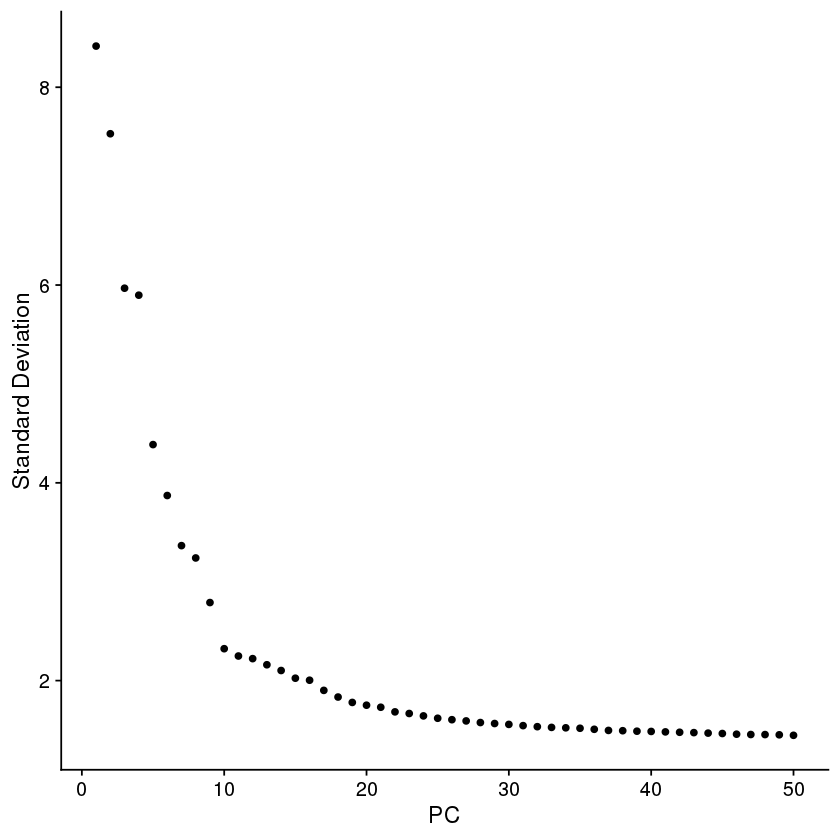

In [13]:
# Dimensional Reduction
dataobj <- RunPCA(dataobj, features = VariableFeatures(object = dataobj),npcs=50)
# Determine the ‘dimensionality’ of the dataset according to elbow plot
ElbowPlot(dataobj,ndim=50) 

In [14]:
pcDim = 30 # set as 75 in this case 

# Cluster the cells
dataobj <- FindNeighbors(dataobj, reduction = "pca", dims = 1:pcDim, nn.eps = 0.5)

Computing nearest neighbor graph

Computing SNN



In [18]:
dataobj <- FindClusters(dataobj, resolution = 0.5, n.start = 5)

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 4177
Number of edges: 161982

Running Louvain algorithm...
Maximum modularity in 5 random starts: 0.9097
Number of communities: 12
Elapsed time: 0 seconds


In [15]:
dataobj <- RunUMAP(dataobj,dims=1:pcDim)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
20:54:58 UMAP embedding parameters a = 0.9922 b = 1.112

20:54:58 Read 4177 rows and found 30 numeric columns

20:54:58 Using Annoy for neighbor search, n_neighbors = 30

20:54:58 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*

|

20:54:59 Writing NN index file to temp file /tmp/Rtmp7Q3ecB/file22fd7799e88c

20:54:59 Searching Annoy index using 1 thread, search_k = 3000

20:55:01 Annoy recall = 100%

20:55:02 Commencing smooth kNN distance calibration using 1 thread

20:55:03 Initializing fr

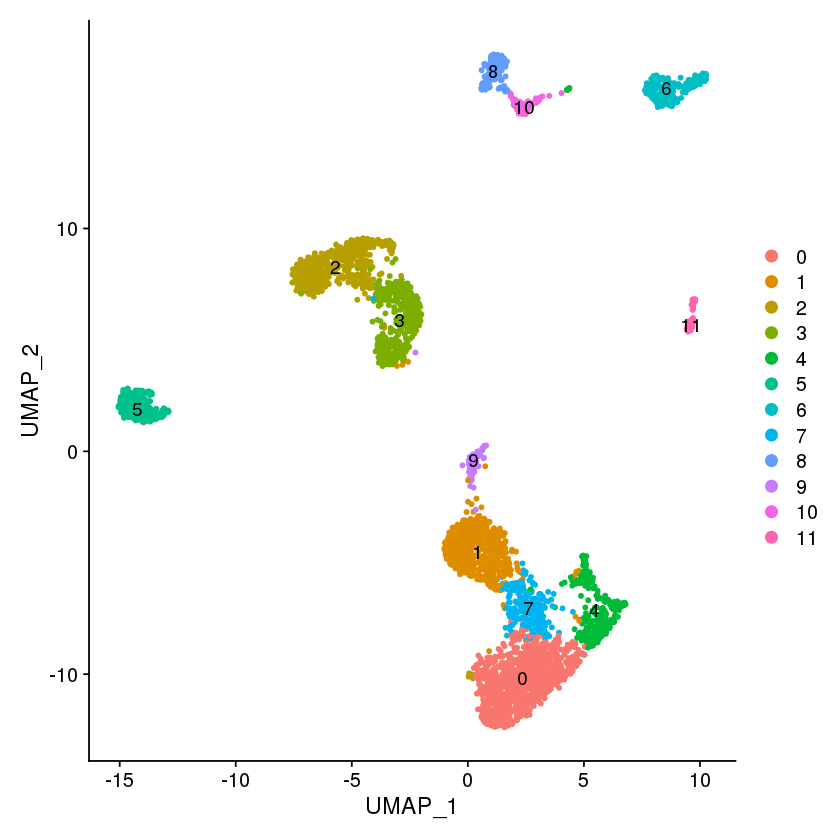

In [19]:
p_umap=DimPlot(dataobj,label = TRUE, pt.size=1)
p_umap

In [37]:
new.cluster.ids <- c("Colon-Connective tissue-Fibroblast-LUM SCARA5",
                     "Colon-Connective tissue-Fibroblast-DCN",
                     "Colon-Connective tissue-Adipocyte-POSTN", 
                     "Colon-Nerve tissue-Schwann cell-APOD", 
                     "Colon-Muscle tissue-Smooth muscle cell-OGN", 
                     "Unclassified",
                     "Colon-Connective tissue-B cell-GNG7", 
                     "Colon-Connective tissue-Fibroblast-DCN",
                     "Colon-Epithelial tissue-Endothelial cell-FLT1", 
                     "Colon-Connective tissue-Fibroblast-MFAP5",
                     "Colon-Epithelial tissue-Endothelial cell-ACKR1", 
                     "Unclassified")

In [36]:
subset(dataobj.markers,cluster=='11')
# subset(dataobj.markers,gene=='C1QA')

,p_val,avg_logFC,pct.1,pct.2,p_val_adj,cluster,gene
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
RGS51,0.000000e+00,2.2955571,0.827,0.022,0.000000e+00,11,RGS5
RERGL,0.000000e+00,2.0993632,0.691,0.006,0.000000e+00,11,RERGL
PLN1,0.000000e+00,1.8860813,0.691,0.008,0.000000e+00,11,PLN
COX4I2,0.000000e+00,1.7587999,0.716,0.007,0.000000e+00,11,COX4I2
NTRK2,0.000000e+00,1.4022765,0.531,0.003,0.000000e+00,11,NTRK2
CDH6,1.440681e-300,1.1639841,0.469,0.004,6.321418e-296,11,CDH6
ECRG4,8.908946e-281,1.6530835,0.654,0.014,3.909067e-276,11,ECRG4
HIGD1B,1.117775e-275,1.4806257,0.457,0.004,4.904575e-271,11,HIGD1B
ITGA7,4.717518e-257,1.0936332,0.395,0.003,2.069953e-252,11,ITGA7


In [38]:
names(x = new.cluster.ids) <- levels(x = dataobj)
annodataobj <- RenameIdents(object = dataobj, new.cluster.ids)

In [39]:
annodataobj <- RunUMAP(annodataobj,dims=1:pcDim)

21:20:32 UMAP embedding parameters a = 0.9922 b = 1.112

21:20:32 Read 4177 rows and found 30 numeric columns

21:20:32 Using Annoy for neighbor search, n_neighbors = 30

21:20:32 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*

|

21:20:34 Writing NN index file to temp file /tmp/Rtmp7Q3ecB/file22fd70456ce4

21:20:34 Searching Annoy index using 1 thread, search_k = 3000

21:20:35 Annoy recall = 100%

21:20:35 Commencing smooth kNN distance calibration using 1 thread

21:20:36 Initializing from normalized Laplacian + noise

21:20:37 Commencing optimization for 500 epochs, with 172876 positive edges

21:20:53 Optimization finished



In [ ]:
p_umap4 <- UMAPPlot(annodataobj,label = T, pt.size=1,label.size=5)+NoLegend()
# LabelClusters(plot = p_umap4, id = 'ident', color = 'white')
ggsave(paste0(datasetName,".seurat.umap_hcad.tiff"), plot = p_umap4, width = 25, height = 15)
p_umap4

In [20]:
dataobj.markers <- FindAllMarkers(dataobj, only.pos = TRUE)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11



In [41]:

write.table(dataobj.markers, file = paste0(datasetName,".seurat.markers.txt"), sep = "\t", quote = F, row.names = F, col.names = T)
# 
dataobj<-AddMetaData(dataobj, metadata =as.character(annodataobj@active.ident),col.name='hcad.label') 

write.table(cbind(colnames(dataobj), dataobj$hcad.label), file = paste0(datasetName,"_annotation.hcad.tsv"), sep = "\t", quote = F, row.names = F, col.names = c('cell_ID','cell_cluster'))

saveRDS(dataobj, file = paste0(datasetName,".seuratobj.rds"))

In [42]:
print(levels(dataobj$sample_status))
dataobj

[1] "normal"


An object of class Seurat 
43878 features across 4177 samples within 1 assay 
Active assay: RNA (43878 features, 2000 variable features)
 2 dimensional reductions calculated: pca, umap

In [44]:
# ncol(result_data_ouhed(t
head(dataobj[[]])

,orig.ident,nCount_RNA,nFeature_RNA,organ,region,subregion,sample_status,donor_ID,donor_gender,donor_age,cell_cluster,RNA_snn_res.1.5,seurat_clusters,RNA_snn_res.0.5,hcad.label
,<fct>,<dbl>,<int>,<fct>,<fct>,<lgl>,<fct>,<fct>,<fct>,<int>,<lgl>,<fct>,<fct>,<fct>,<chr>
AAACCTGCAAGGACTG.S66,SeuratProject,3556.285,2276,Colon,Colon,NA,normal,S66,Male,55,NA,3,2,2,Colon-Connective tissue-Adipocytes-POSTN
AAACCTGCACAACTGT.S66,SeuratProject,2451.564,1109,Colon,Colon,NA,normal,S66,Male,55,NA,6,7,7,Colon-Connective tissue-Fibroblast-DCN
AAACCTGCACCCTATC.S66,SeuratProject,2810.549,1427,Colon,Colon,NA,normal,S66,Male,55,NA,0,0,0,Colon-Connective tissue-Fibroblast-LUM SCARA5
AAACCTGCAGGCTCAC.S66,SeuratProject,2616.901,1254,Colon,Colon,NA,normal,S66,Male,55,NA,6,7,7,Colon-Connective tissue-Fibroblast-DCN
AAACCTGCAGTCTTCC.S66,SeuratProject,3235.787,1844,Colon,Colon,NA,normal,S66,Male,55,NA,11,0,0,Colon-Connective tissue-Fibroblast-LUM SCARA5
AAACCTGGTCATACTG.S66,SeuratProject,2981.523,1561,Colon,Colon,NA,normal,S66,Male,55,NA,9,2,2,Colon-Connective tissue-Adipocytes-POSTN


In [45]:
dataobj.dbupload_v1 <- CreateSeuratObject(result_data_out)
# dataobj.dbupload_v1 <- NormalizeData(dataobj.dbupload_v1, normalization.method = "LogNormalize", scale.factor = 10000)
dataobj.dbupload_v1[['orig.ident']] <- NULL
dataobj.dbupload_v1[['nCount_RNA']] <- NULL
dataobj.dbupload_v1[['nFeature_RNA']] <- NULL
dataobj.dbupload_v1$user_id <- 1
dataobj.dbupload_v1$study_id<-"10.1016/j.cell.2018.08.067"
dataobj.dbupload_v1$cell_id <- colnames(dataobj.dbupload_v1@assays$RNA@data)
dataobj.dbupload_v1$organ<-"Colon"
dataobj.dbupload_v1$region<-"NA"
dataobj.dbupload_v1$subregion<-"NA"
dataobj.dbupload_v1$seq_tech<-"10X"
dataobj.dbupload_v1$sample_status<-"Healthy"
dataobj.dbupload_v1$donor_id<-dataobj$donor_ID
dataobj.dbupload_v1$donor_gender<-dataobj$donor_gender
dataobj.dbupload_v1$donor_age<- dataobj$donor_age
dataobj.dbupload_v1$original_name<-dataobj$cell_cluster
dataobj.dbupload_v1$cl_name<-"NA"
dataobj.dbupload_v1$hcad_name<-dataobj$hcad.label

In [46]:
dataobj.dbupload_v1$original_name<-as.character(dataobj.dbupload_v1$original_name)
dataobj.dbupload_v1$donor_id<-as.character(dataobj.dbupload_v1$donor_id)
dataobj.dbupload_v1$donor_gender<-as.character(dataobj.dbupload_v1$donor_gender)

In [18]:
saveRDS(dataobj.dbupload_v1, file = paste0(datasetName,".seuratobj.dbupload_v1.rds"))

In [47]:
colnames(dataobj.dbupload_v1@meta.data)

[1] "user_id"       "study_id"      "cell_id"       "organ"        
 [5] "region"        "subgion"       "seq_tech"      "sample_status"
 [9] "donor_id"      "donor_gender"  "donor_age"     "original_name"
[13] "cl_name"       "hcad_name"

In [3]:
dataobj.dbupload_v1 <- readRDS(paste0(datasetName,".seuratobj.dbupload_v1.rds"))

In [5]:
colnames(dataobj.dbupload_v1@meta.data)[6] <- 'subregion'

In [14]:
unique(dataobj.dbupload_v1$donor_age)

[1] "55" "65"

In [15]:
dataobj.dbupload_v1$donor_age<- sub("55","55yr",dataobj.dbupload_v1$donor_age)
dataobj.dbupload_v1$donor_age<- sub("65","65yr",dataobj.dbupload_v1$donor_age)

In [10]:
dataobj.dbupload_v1$donor_age<-as.character(dataobj.dbupload_v1$donor_age)

In [4]:
dataobj.dbupload_v1$hcad_name<- sub("Adipocytes","Adipocyte",dataobj.dbupload_v1$hcad_name)
unique(dataobj.dbupload_v1[['hcad_name']])

,hcad_name
,<chr>
AAACCTGCAAGGACTG.S66,Colon-Connective tissue-Adipocyte-POSTN
AAACCTGCACAACTGT.S66,Colon-Connective tissue-Fibroblast-DCN
AAACCTGCACCCTATC.S66,Colon-Connective tissue-Fibroblast-LUM SCARA5
AAACCTGGTGTAATGA.S66,Unknown
AAACGGGAGATCTGCT.S66,Colon-Connective tissue-B cell-GNG7
AACCGCGAGGACACCA.S66,Colon-Muscle tissue-Smooth muscle cell-OGN
AACGTTGCAAGCGATG.S66,Colon-Epithelial tissue-Endothelial cell-FLT1
AACTCTTGTGTTTGGT.S66,Colon-Epithelial tissue-Endothelial cell-ACKR1
AACTGGTTCGCTGATA.S66,Colon-Connective tissue-Fibroblast-MFAP5


In [5]:
saveRDS(dataobj.dbupload_v1, file = paste0(datasetName,".seuratobj.dbupload_v1.rds"))